<a href="https://colab.research.google.com/github/matteoalberti/Lectures_introCV_Experis2020/blob/main/DL4CV_0_Introduction_to_OpenCV_%26_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](images/intro.jpg)

# **Welcome!**

## Introduction to Machine Learning



## **Lecturer :** Matteo Alberti

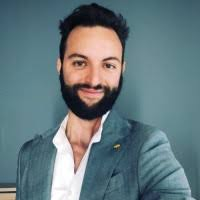

*Contacts :* https://www.linkedin.com/in/matteo-alberti-170493/


# Summary

- <font color=BE3315>**Introduction to Computer Vision datasets** </font> 
- <font color=E15234>**Standart preprocessing to images** </font> 
- <font color=EF8932>**filtering and denoising** </font> 

#### Load Packages

In [1]:
import os
import pickle
import pandas as pd
import argparse
from random import randint
import time
import gc
import cv2
import platform
import numpy as np

#Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

print('Python Version : ', platform.python_version())

Python Version :  3.6.9


##### Load Cifar10 data from Local File
available at: https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
data_path = './data/Interactive_Session'

# necessary for load our data
batch_id = 3
sample_id = 7000

In [ ]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[0]
    sample_label = labels[0]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)
    return features, labels

##### Visulize Data & Stats


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


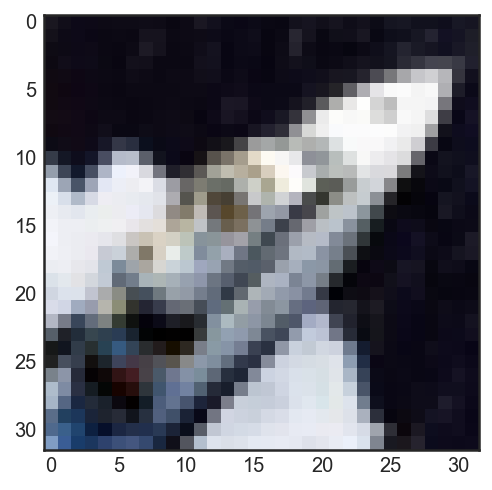

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Explore the dataset
features, labels = display_stats(data_path, batch_id, sample_id)

##### Split out Data

In [ ]:
x_train = features[:int((features.shape[0]/100)*70)]
y_train = labels[:int((features.shape[0]/100)*70)]
y_train = np.asarray(y_train)

x_test = features[:features.shape[0] - x_train.shape[0]]
y_test = labels[:features.shape[0] - x_train.shape[0]]
y_test = np.asarray(y_test)

x_val = x_test[:2000]
x_test = x_test[2000:]

y_val = y_test[:2000]
y_test = y_test[2000:]

print(x_train.shape,y_train.shape, x_val.shape, y_val.shape, x_test.shape,y_test.shape )

(7000, 32, 32, 3) (7000,) (2000, 32, 32, 3) (2000,) (1000, 32, 32, 3) (1000,)


First of all :

    Computers 'look' at images as multidimensional arrays or matricies but they can also be treated like functions
    

In [ ]:
x_train[0][0][:10]

array([[26, 23, 32],
       [17, 14, 25],
       [13,  9, 24],
       [13,  9, 23],
       [13, 10, 21],
       [14, 11, 22],
       [14, 11, 22],
       [15, 12, 23],
       [14, 11, 22],
       [10,  7, 18]], dtype=uint8)

In [ ]:
y_train[0]

8

In [ ]:
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

Let me explain with 4 classes and 4 vs 2 bit encoding

dog, cat, bird, tuna 

2 bit encoding :

    dog = 00
    cat = 01
    bird = 10
    tuna = 11

But dog<cat<bird<tuna?

Obviosly not.. so that we need to encode in another way :

    dog = 0000
    cat = 0010
    bird = 0100
    tuna = 1000


Many times, images contain complex information that isn't need for a computation or reduces the speed of computation without much value added.

##### Normalize data

In [ ]:
print('Range : ', np.amin(x_train[0]),' - ', np.amax(x_train[0]))

Range :  0  -  254


In [ ]:
#The range for each individual colour is 0-255
x_train = x_train.astype('float32')/255 
x_val = x_val.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
x_train[0][0][:10]

array([[0.10196079, 0.09019608, 0.1254902 ],
       [0.06666667, 0.05490196, 0.09803922],
       [0.05098039, 0.03529412, 0.09411765],
       [0.05098039, 0.03529412, 0.09019608],
       [0.05098039, 0.03921569, 0.08235294],
       [0.05490196, 0.04313726, 0.08627451],
       [0.05490196, 0.04313726, 0.08627451],
       [0.05882353, 0.04705882, 0.09019608],
       [0.05490196, 0.04313726, 0.08627451],
       [0.03921569, 0.02745098, 0.07058824]], dtype=float32)

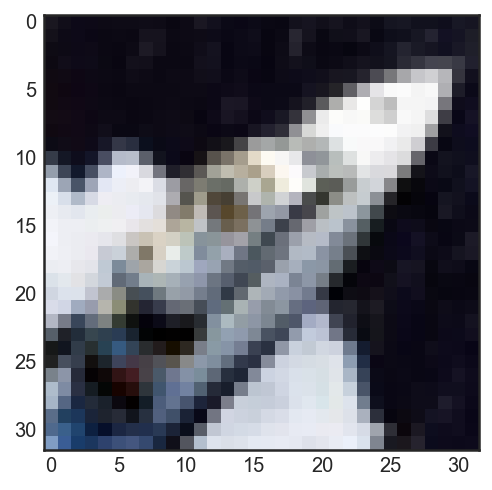

In [ ]:
plt.imshow(x_train[0])

### Some basics Image Filters and Functions

**Blurring** is useful when there is noise in an image you want to remove.

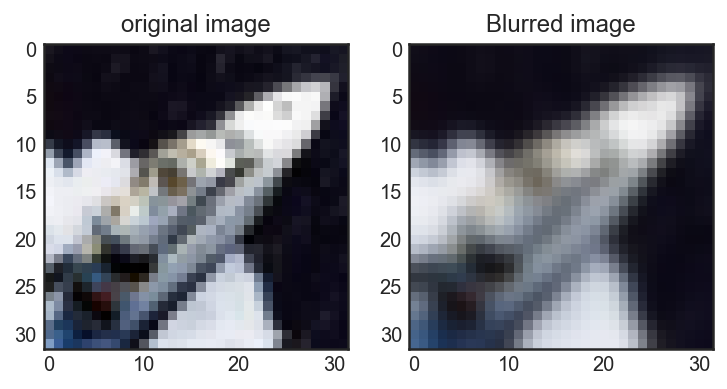

In [ ]:
blur_img = x_train[0].copy()
blur_img = cv2.GaussianBlur(blur_img, (41, 41), 1)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train[0])
plt.title('original image')
f.add_subplot(1,2, 2)
plt.imshow(blur_img)
plt.title('Blurred image')
plt.show(block=True)

**Dilation**, as it sounds, dilates pixel neighbourhoods by finding maximums over the image by the kernel size given. This is useful for expanding selections

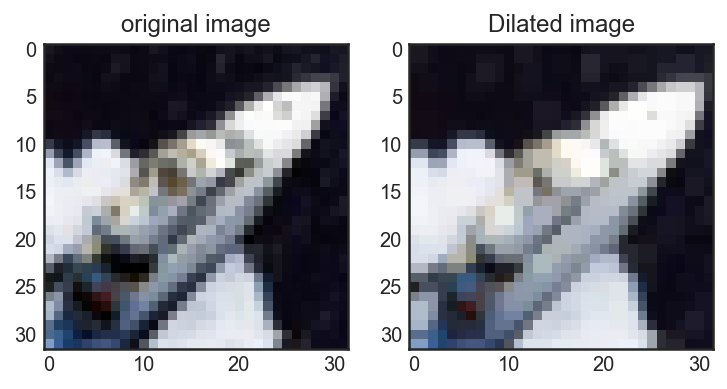

In [ ]:
dilate_img = x_train[0].copy()
dilate_img = cv2.dilate(dilate_img, np.ones((2,2), dtype=np.uint8), iterations=1)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train[0])
plt.title('original image')
f.add_subplot(1,2, 2)
plt.imshow(dilate_img)
plt.title('Dilated image')
plt.show(block=True)

**Erosion** is the opposite of dilation, useful for remove noise

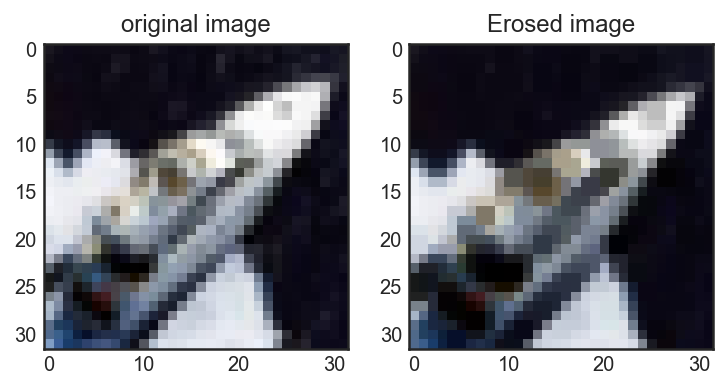

In [ ]:
erosion_img = x_train[0].copy()
erosion_img = cv2.erode(erosion_img, np.ones((2,2), dtype=np.uint8), iterations=1)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train[0])
plt.title('original image')
f.add_subplot(1,2, 2)
plt.imshow(erosion_img)
plt.title('Erosed image')
plt.show(block=True)

**Canny edge detector** : Userful for image masking

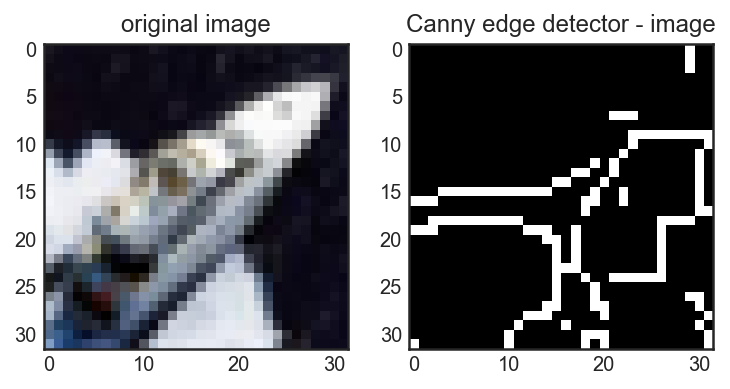

In [ ]:
canny_img = x_train[0].copy()
canny_img = cv2.erode(canny_img, np.ones((8,8), dtype=np.uint8), iterations=1)
edges = cv2.Canny(canny_img,25,25)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train[0])
plt.title('original image')
f.add_subplot(1,2, 2)
plt.imshow(edges.astype(np.uint8), cmap='gray')
plt.title('Canny edge detector - image')
plt.show(block=True)

**Thresholding** can be thought of as a function applied to each pixel of an image. This function takes a min and max thresholding values and if the pixel value falls in this range

**Very userful with medical images**

(32, 32)


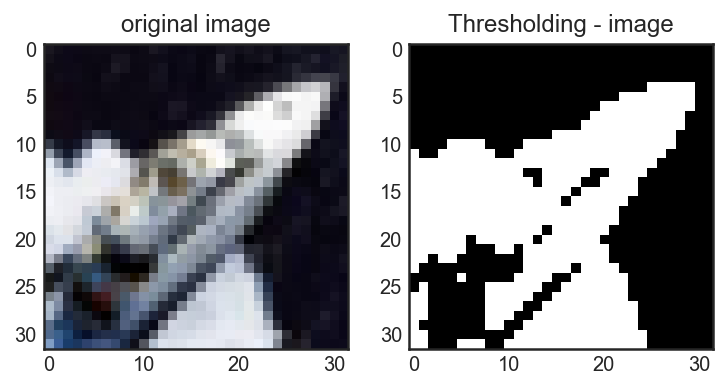

In [ ]:
thresh_img = x_train[0].copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 80, 255, cv2.THRESH_BINARY)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_train[0])
plt.title('original image')
f.add_subplot(1,2, 2)
plt.imshow(thresh, cmap='gray')
print(thresh.shape)
plt.title('Thresholding - image')
plt.show(block=True)

### Mask

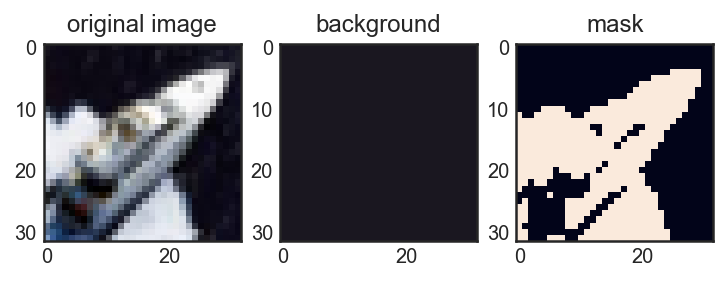

In [ ]:
bg = np.array([[[ 26,  23,  32]]*32]*32)
cv2.imwrite('bg.jpg', bg)
bg_cv = cv2.imread('bg.jpg')
cv2.imwrite('x_train.jpg', x_train[0])
x_train_cv = cv2.imread('x_train.jpg')
diff = cv2.absdiff(bg_cv, x_train_cv)
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
th, mask_thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
mask_indexes = mask_thresh > 0

f = plt.figure()
f.add_subplot(1,3,1)
plt.imshow(x_train[0])
plt.title('original image')
f.add_subplot(1,3, 2)
plt.imshow(bg)
plt.title('background')
f.add_subplot(1,3,3)
plt.imshow(bg_img)
plt.title('mask')




plt.show(block=True)